In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acovf

In [ ]:
n=60
t=np.arange(n)
beta0=100
beta1=2
A=40
p=12
sigma=5

# Génération du bruit
trend = beta0 + beta1 * t
seasonality = A * np.sin(2 * np.pi * t / p)
noise = np.random.normal(0, sigma, n)

# Génération de la série temporelle
sales = trend + seasonality + noise

#cre un DataFrame pandas
dates = pd.date_range(start='2020-01-01', periods=n, freq='M')
data = pd.DataFrame({'Date': dates, 'Sales': sales, 'Trend': trend, 'Seasonality': seasonality, 'Noise': noise})

C:\Users\0000\AppData\Local\Temp\ipykernel_22000\3236058695.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(start='2020-01-01', periods=n, freq='M')


## Creation de la serie

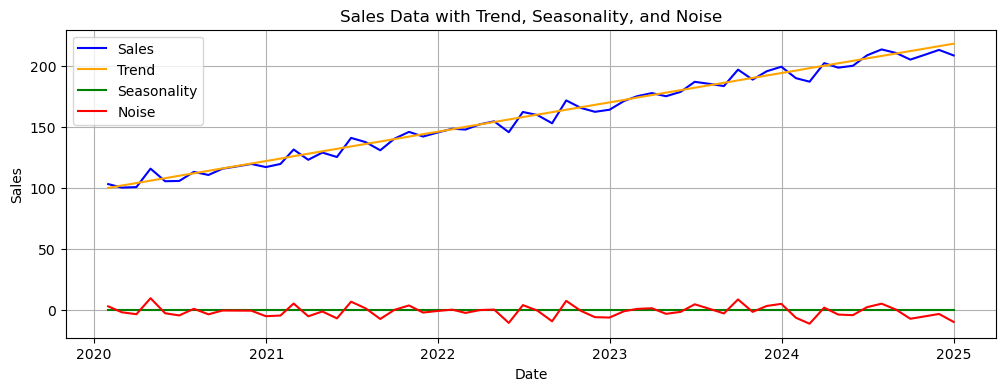

In [3]:
# Visualisation
plt.figure(figsize=(12, 4))
plt.plot(data['Date'], data['Sales'], label='Sales', color='blue')
plt.plot(data['Date'], data['Trend'], label='Trend', color='orange')
plt.plot(data['Date'], data['Seasonality'], label='Seasonality', color='green')
plt.plot(data['Date'], data['Noise'], label='Noise', color='red')
plt.title('Sales Data with Trend, Seasonality, and Noise')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid()
plt.legend()
plt.show()

## Visualiser les autocovariance et autocorrelation

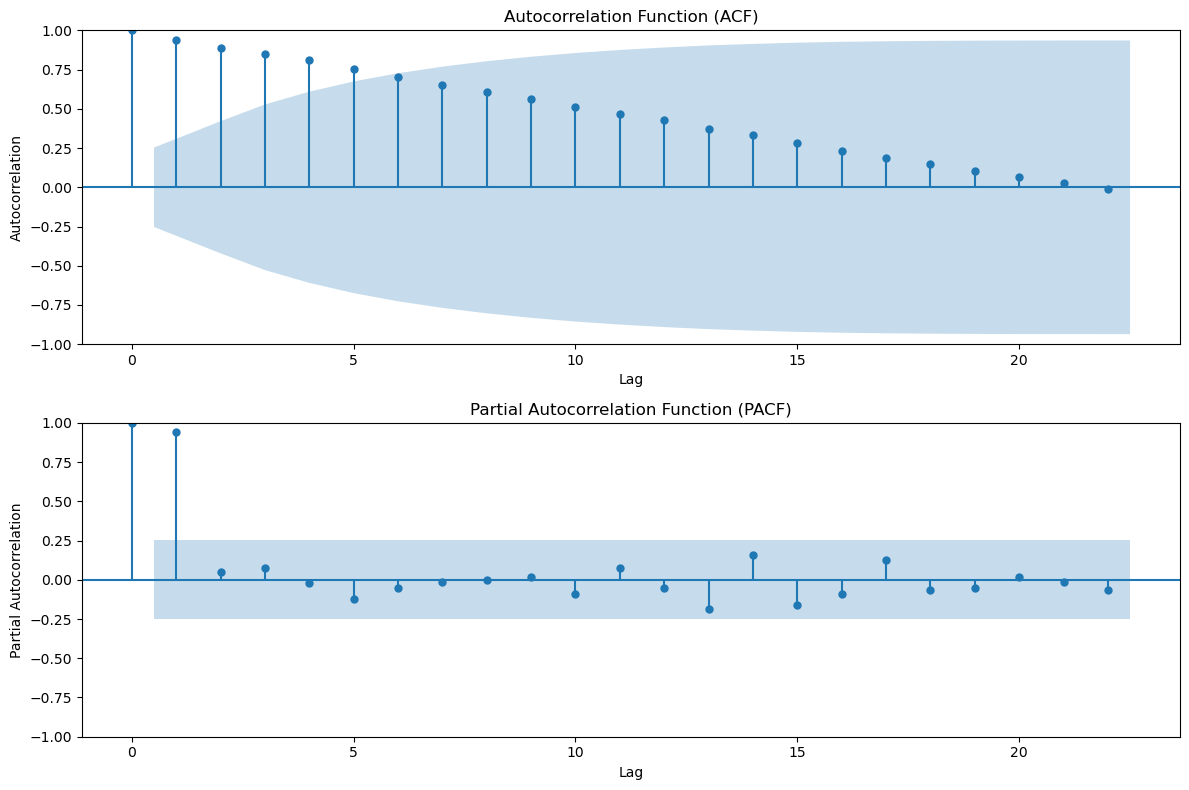

Autocovariances (premiers 40 lags):
Lag 0: 1188.4189
Lag 1: 1117.2164
Lag 2: 1057.0644
Lag 3: 1010.2503
Lag 4: 961.3250
Lag 5: 897.8124
Lag 6: 833.5301
Lag 7: 774.1000
Lag 8: 718.3792
Lag 9: 666.4348
Lag 10: 604.2280
Lag 11: 558.3838
Lag 12: 509.3517
Lag 13: 438.3327
Lag 14: 394.9821
Lag 15: 337.9985
Lag 16: 271.0778
Lag 17: 222.7518
Lag 18: 177.0400
Lag 19: 122.7562


In [16]:
# Créer une figure avec deux sous-graphiques
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Autocorrélation (ACF)
plot_acf(data['Sales'], lags=22, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')
axes[0].set_xlabel('Lag')
axes[0].set_ylabel('Autocorrelation')

# Autocorrélation partielle (PACF)
plot_pacf(data['Sales'], lags=22, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')
axes[1].set_xlabel('Lag')
axes[1].set_ylabel('Partial Autocorrelation')

plt.tight_layout()
plt.show()

# Calculer et afficher les valeurs d'autocovariance
autocovariances = acovf(data['Sales'], fft=False)
print("Autocovariances (premiers 40 lags):")
for i in range(min(20, len(autocovariances))):
    print(f"Lag {i}: {autocovariances[i]:.4f}")

In [5]:
# Voyons la stationnarite

result = adfuller(data['Sales'])
print('ADF Statistic:', result[0])
print('p-value:', result[1])

ADF Statistic: -0.6363559760785807
p-value: 0.8625536703658516


### Interpretation

##### La série n'est PAS stationnaire :

* La p-value (0.862) est beaucoup plus grande que 0.05, ce qui signifie qu'on ne peut pas rejeter l'hypothèse nulle
* L'hypothèse nulle du test ADF est que la série possède une racine unitaire (elle est non-stationnaire)

### Rendons la serie,une serie stationnaire

In [6]:
## Rendons la serie,une serie stationnaire
data['Sales_diff'] = data['Sales'].diff()
result_diff = adfuller(data['Sales_diff'].dropna())
print('ADF Statistic (differenced):', result_diff[0])
print('p-value (differenced):', result_diff[1])

ADF Statistic (differenced): -4.7557309337545
p-value (differenced): 6.604461006966492e-05


### La serie EST stationnaire maintenant!

In [7]:
from statsmodels.tsa.ar_model import AutoReg

# Préparer les données sans NaN
sales_diff_clean = data['Sales_diff'].dropna()

# Modèle AutoRegressif (AR)
ar_model = AutoReg(sales_diff_clean, lags=1)
ar_fit = ar_model.fit()

print("=" * 60)
print("MODÈLE AUTO-REGRESSIF (AR)")
print("=" * 60)
print(ar_fit.summary())
print("\n")

MODÈLE AUTO-REGRESSIF (AR)
                            AutoReg Model Results                             
Dep. Variable:             Sales_diff   No. Observations:                   59
Model:                     AutoReg(1)   Log Likelihood                -188.000
Method:               Conditional MLE   S.D. of innovations              6.187
Date:                Mon, 27 Oct 2025   AIC                            382.001
Time:                        18:09:01   BIC                            388.182
Sample:                             1   HQIC                           384.409
                                   59                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             2.7201      0.842      3.229      0.001       1.069       4.371
Sales_diff.L1    -0.4524      0.118     -3.847      0.000      -0.683      -0.222
             

c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [8]:
## 3. Modèle SARIMA (Seasonal ARIMA)
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Préparer les données sans NaN
sales_diff_clean = data['Sales_diff'].dropna()

# Modèle SARIMA avec composante saisonnière (période=12 mois)
# SARIMA(p,d,q)(P,D,Q,s) = SARIMA(1,0,1)(1,0,1,12)
sarima_model = SARIMAX(sales_diff_clean, 
                        order=(1, 0, 1),
                        seasonal_order=(1, 0, 1, 12))
sarima_fit = sarima_model.fit(disp=False)

print("=" * 60)
print("MODÈLE SARIMA(1,0,1)(1,0,1,12)")
print("=" * 60)
print(sarima_fit.summary())
print("\n")

c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


MODÈLE SARIMA(1,0,1)(1,0,1,12)
                                     SARIMAX Results                                      
Dep. Variable:                         Sales_diff   No. Observations:                   59
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -188.820
Date:                            Mon, 27 Oct 2025   AIC                            387.640
Time:                                    18:09:01   BIC                            398.028
Sample:                                         0   HQIC                           391.695
                                             - 59                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0399      0.317     -0.126      0.900      -0.660       0.581
ma.L

In [9]:
## Appliquons les modèles ARIMA sur la série stationnaire
from statsmodels.tsa.arima.model import ARIMA

# Préparer les données sans NaN
sales_diff_clean = data['Sales_diff'].dropna()

# Définir le modèle ARIMA
model = ARIMA(sales_diff_clean, order=(1, 0, 1))
model_fit = model.fit()

# Résumé du modèle
print(model_fit.summary())

c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             Sales_diff   No. Observations:                   59
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -175.554
Date:                Mon, 27 Oct 2025   AIC                            359.108
Time:                        18:09:01   BIC                            367.418
Sample:                             0   HQIC                           362.352
                                 - 59                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9752      0.043     46.177      0.000       1.891       2.059
ar.L1         -0.1360      0.157     -0.866      0.387      -0.444       0.172
ma.L1         -0.9999     35.190     -0.028      0.9

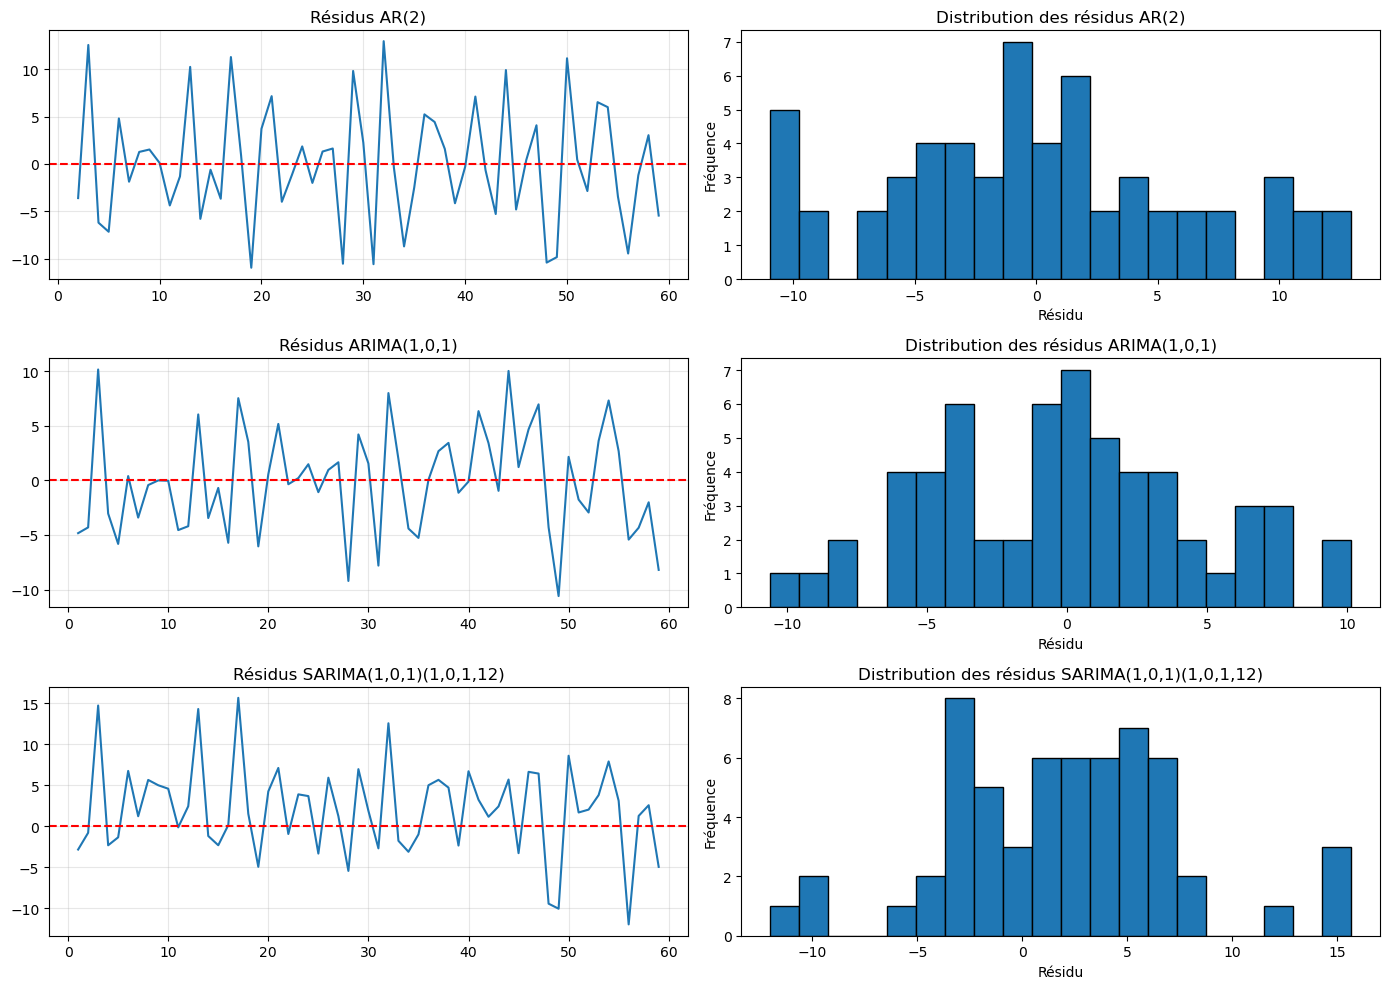

In [10]:
## Analyse des résidus pour chaque modèle
fig, axes = plt.subplots(3, 2, figsize=(14, 10))

# AR Residuals
ar_residuals = ar_fit.resid
axes[0, 0].plot(ar_residuals)
axes[0, 0].set_title('Résidus AR(2)')
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].grid(True, alpha=0.3)

axes[0, 1].hist(ar_residuals, bins=20, edgecolor='black')
axes[0, 1].set_title('Distribution des résidus AR(2)')
axes[0, 1].set_xlabel('Résidu')
axes[0, 1].set_ylabel('Fréquence')

# ARIMA Residuals
arima_residuals = model_fit.resid
axes[1, 0].plot(arima_residuals)
axes[1, 0].set_title('Résidus ARIMA(1,0,1)')
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(arima_residuals, bins=20, edgecolor='black')
axes[1, 1].set_title('Distribution des résidus ARIMA(1,0,1)')
axes[1, 1].set_xlabel('Résidu')
axes[1, 1].set_ylabel('Fréquence')

# SARIMA Residuals
sarima_residuals = sarima_fit.resid
axes[2, 0].plot(sarima_residuals)
axes[2, 0].set_title('Résidus SARIMA(1,0,1)(1,0,1,12)')
axes[2, 0].axhline(y=0, color='r', linestyle='--')
axes[2, 0].grid(True, alpha=0.3)

axes[2, 1].hist(sarima_residuals, bins=20, edgecolor='black')
axes[2, 1].set_title('Distribution des résidus SARIMA(1,0,1)(1,0,1,12)')
axes[2, 1].set_xlabel('Résidu')
axes[2, 1].set_ylabel('Fréquence')

plt.tight_layout()
plt.show()

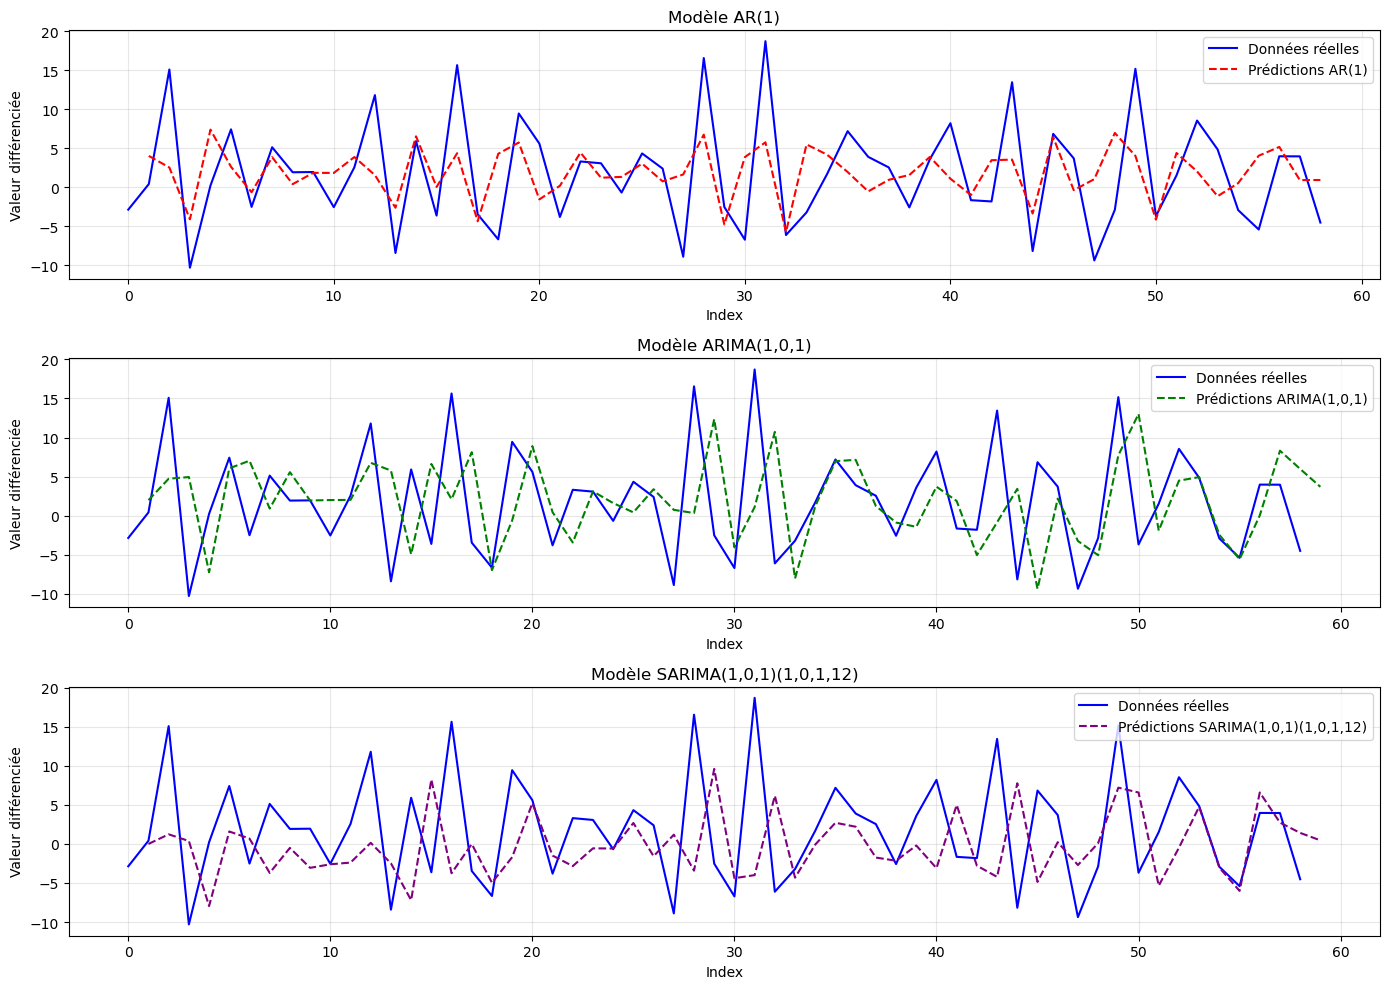

In [11]:
## Visualisation des prédictions des trois modèles
sales_diff_clean = data['Sales_diff'].dropna()

fig, axes = plt.subplots(3, 1, figsize=(14, 10))

# AR Model
ar_pred = ar_fit.predict(start=0, end=len(sales_diff_clean)-1)
axes[0].plot(sales_diff_clean.values, label='Données réelles', color='blue')
axes[0].plot(ar_pred, label='Prédictions AR(1)', color='red', linestyle='--')
axes[0].set_title('Modèle AR(1)')
axes[0].set_xlabel('Index')
axes[0].set_ylabel('Valeur différenciée')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# ARIMA Model
arima_pred = model_fit.fittedvalues
axes[1].plot(sales_diff_clean.values, label='Données réelles', color='blue')
axes[1].plot(arima_pred, label='Prédictions ARIMA(1,0,1)', color='green', linestyle='--')
axes[1].set_title('Modèle ARIMA(1,0,1)')
axes[1].set_xlabel('Index')
axes[1].set_ylabel('Valeur différenciée')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# SARIMA Model
sarima_pred = sarima_fit.fittedvalues
axes[2].plot(sales_diff_clean.values, label='Données réelles', color='blue')
axes[2].plot(sarima_pred, label='Prédictions SARIMA(1,0,1)(1,0,1,12)', color='purple', linestyle='--')
axes[2].set_title('Modèle SARIMA(1,0,1)(1,0,1,12)')
axes[2].set_xlabel('Index')
axes[2].set_ylabel('Valeur différenciée')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [12]:
## Comparaison des modèles avec AIC et BIC
print("=" * 60)
print("COMPARAISON DES MODÈLES")
print("=" * 60)

comparison = pd.DataFrame({
    'Modèle': ['AR(1)', 'ARIMA(1,0,1)', 'SARIMA(1,0,1)(1,0,1,12)'],
    'AIC': [ar_fit.aic, model_fit.aic, sarima_fit.aic],
    'BIC': [ar_fit.bic, model_fit.bic, sarima_fit.bic]
})

print(comparison)
print("\nNote: Plus l'AIC/BIC est faible, meilleur est le modèle")
print(f"\nMeilleur modèle (AIC): {comparison.loc[comparison['AIC'].idxmin(), 'Modèle']}")
print(f"Meilleur modèle (BIC): {comparison.loc[comparison['BIC'].idxmin(), 'Modèle']}")

COMPARAISON DES MODÈLES
                    Modèle         AIC         BIC
0                    AR(1)  382.000758  388.182087
1             ARIMA(1,0,1)  359.107715  367.417865
2  SARIMA(1,0,1)(1,0,1,12)  387.640148  398.027835

Note: Plus l'AIC/BIC est faible, meilleur est le modèle

Meilleur modèle (AIC): ARIMA(1,0,1)
Meilleur modèle (BIC): ARIMA(1,0,1)


### Faisons le forcasting avec les models

RÉSULTATS DES PRÉVISIONS - SARIMA(1,0,1)(1,0,1,12)

🔮 Prévisions pour les 12 prochains mois :
  2025-01: 208.3
  2025-02: 207.5
  2025-03: 214.2
  2025-04: 212.5
  2025-05: 213.2
  2025-06: 218.4
  2025-07: 220.1
  2025-08: 218.4
  2025-09: 218.4
  2025-10: 219.0
  2025-11: 221.3
  2025-12: 219.9

⚠️  ATTENTION - Qualité du modèle :
   • Coefficients AR/MA non significatifs (p-value > 0.05)
   • Intervalles de confiance très larges
   • Ces prévisions sont PEU FIABLES

📊 Intervalles de confiance (95%) :
  2025-01: [197.0, 219.5]
  2025-02: [194.8, 220.5]
  2025-03: [202.2, 227.9]
  2025-04: [193.9, 219.6]
  2025-05: [196.3, 221.9]
  2025-06: [200.8, 226.4]
  2025-07: [197.3, 223.0]
  2025-08: [193.9, 219.5]
  2025-09: [195.6, 221.3]
  2025-10: [196.1, 221.8]
  2025-11: [197.9, 223.5]
  2025-12: [194.2, 219.9]

📈 Performance du modèle :
   AIC: 387.64
   BIC: 398.03
   Log-Likelihood: -188.82


c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


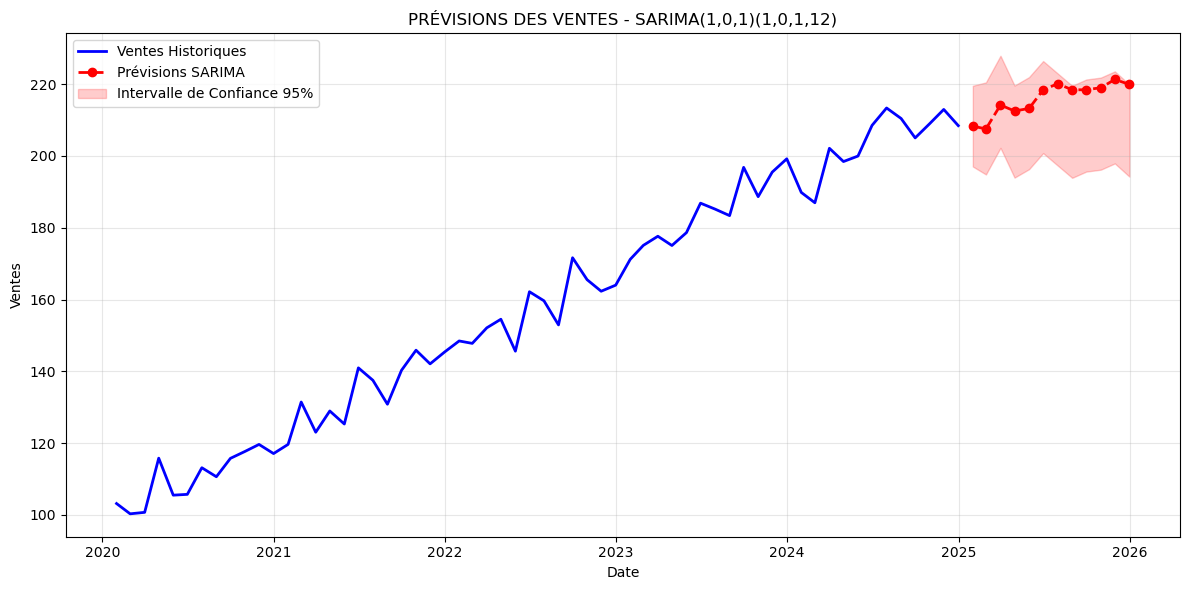


🔍 ANALYSE DES RÉSIDUS :
   • Moyenne des résidus: 2.0427
   • Écart-type des résidus: 5.5904
   • Test Ljung-Box (p-value): 0.2242


In [13]:
# 1. FAIRE LES PRÉVISIONS
forecast_steps = 12  # Prévoir les 12 prochains mois
forecast = sarima_fit.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
forecast_ci = forecast.conf_int()

# 2. CRÉER LES DATES DE PRÉVISION
last_date = data['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='ME')

# 3. CONVERTIR LES PRÉVISIONS EN NIVEAU ORIGINAL
last_sales_value = data['Sales'].iloc[-1]

# Reconstruction de la série originale
forecast_original = []
current_value = last_sales_value

for i in range(len(forecast_mean)):
    diff_value = forecast_mean.iloc[i]
    current_value = current_value + diff_value
    forecast_original.append(current_value)

# Créer la série avec les bonnes dates
forecast_original = pd.Series(forecast_original, 
                             index=forecast_dates,
                             name='Sales_forecast')

# 4. AFFICHER LES RÉSULTATS DES PRÉVISIONS
print("=" * 70)
print("RÉSULTATS DES PRÉVISIONS - SARIMA(1,0,1)(1,0,1,12)")
print("=" * 70)

print(f"\n🔮 Prévisions pour les {forecast_steps} prochains mois :")
for date, value in zip(forecast_original.index, forecast_original):
    print(f"  {date.strftime('%Y-%m')}: {value:.1f}")

print(f"\n⚠️  ATTENTION - Qualité du modèle :")
print("   • Coefficients AR/MA non significatifs (p-value > 0.05)")
print("   • Intervalles de confiance très larges")
print("   • Ces prévisions sont PEU FIABLES")

# 5. INTERVALLES DE CONFIANCE POUR LES PRÉVISIONS ORIGINALES
print(f"\n📊 Intervalles de confiance (95%) :")
for i, date in enumerate(forecast_dates):
    lower_diff = forecast_ci.iloc[i, 0]
    upper_diff = forecast_ci.iloc[i, 1]
    
    lower_original = last_sales_value + lower_diff
    upper_original = last_sales_value + upper_diff
    
    print(f"  {date.strftime('%Y-%m')}: [{lower_original:.1f}, {upper_original:.1f}]")

# 6. MÉTRIQUES DE PRÉCISION
print(f"\n📈 Performance du modèle :")
print(f"   AIC: {sarima_fit.aic:.2f}")
print(f"   BIC: {sarima_fit.bic:.2f}")
print(f"   Log-Likelihood: {sarima_fit.llf:.2f}")

# 7. VISUALISATION DES PRÉVISIONS
plt.figure(figsize=(12, 6))

# Données historiques
plt.plot(data['Date'], data['Sales'], label='Ventes Historiques', color='blue', linewidth=2)

# Prévisions
plt.plot(forecast_original.index, forecast_original, 
         label='Prévisions SARIMA', color='red', linestyle='--', linewidth=2, marker='o')

# Intervalles de confiance
forecast_ci_original_lower = last_sales_value + forecast_ci.iloc[:, 0].values
forecast_ci_original_upper = last_sales_value + forecast_ci.iloc[:, 1].values

plt.fill_between(forecast_dates, 
                 forecast_ci_original_lower,
                 forecast_ci_original_upper,
                 color='red', alpha=0.2, label='Intervalle de Confiance 95%')

plt.title('PRÉVISIONS DES VENTES - SARIMA(1,0,1)(1,0,1,12)')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. ANALYSE DES RÉSIDUS
print(f"\n🔍 ANALYSE DES RÉSIDUS :")
residuals = sarima_fit.resid

print(f"   • Moyenne des résidus: {residuals.mean():.4f}")
print(f"   • Écart-type des résidus: {residuals.std():.4f}")

# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
try:
    lb_test = acorr_ljungbox(residuals, lags=1, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   • Test Ljung-Box (p-value): {lb_pvalue:.4f}")
except:
    print("   • Test Ljung-Box: Non disponible")




📈 Performance du modèle :
   AIC: 382.00
   BIC: 388.18
   Log-Likelihood: -188.00


c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


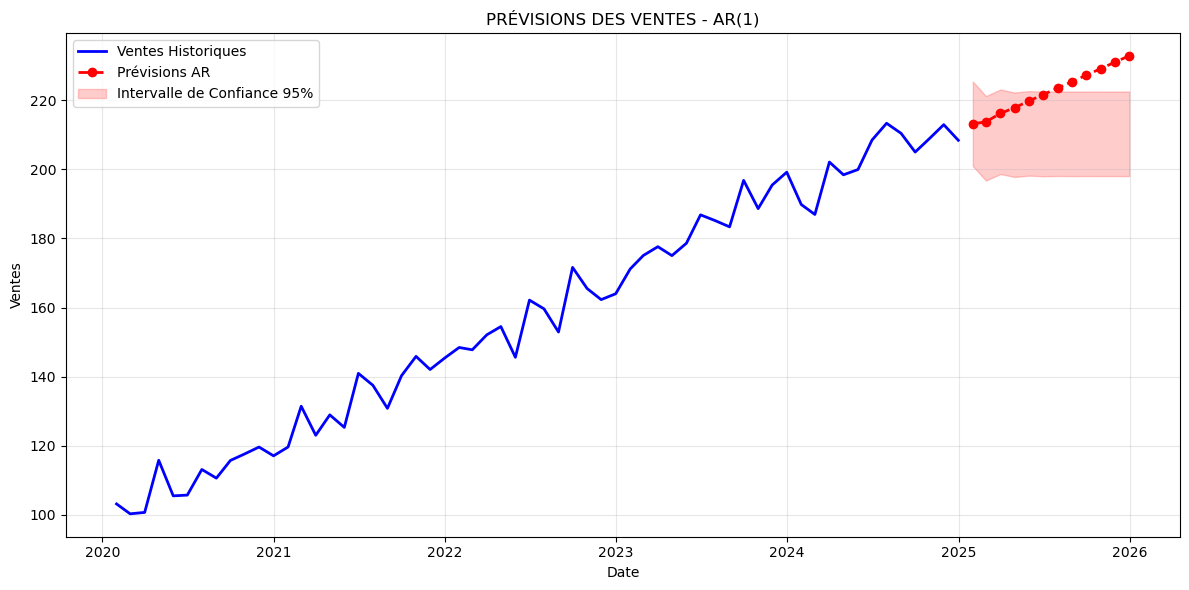


🔍 ANALYSE DES RÉSIDUS :
   • Moyenne des résidus: -0.0000
   • Écart-type des résidus: 6.2410
   • Test Ljung-Box (p-value): 0.0284


In [14]:
## Model AR
# 1. FAIRE LES PRÉVISIONS
forecast_steps = 12  # Prévoir les 12 prochains mois
forecast_mean = ar_fit.forecast(steps=forecast_steps)

# Pour les intervalles de confiance, il faut les calculer manuellement
# car AutoReg ne fournit pas directement get_forecast avec conf_int
std_err = ar_fit.resid.std()
import scipy.stats as stats
z_score = stats.norm.ppf(0.975)  # 95% confidence interval

forecast_ci_lower = forecast_mean - z_score * std_err
forecast_ci_upper = forecast_mean + z_score * std_err

# 2. CRÉER LES DATES DE PRÉVISION
last_date = data['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='ME')

# 3. CONVERTIR LES PRÉVISIONS EN NIVEAU ORIGINAL
last_sales_value = data['Sales'].iloc[-1]

# Reconstruction de la série originale
forecast_original = []
current_value = last_sales_value

for i in range(len(forecast_mean)):
    diff_value = forecast_mean.iloc[i]
    current_value = current_value + diff_value
    forecast_original.append(current_value)

# Créer la série avec les bonnes dates
forecast_original = pd.Series(forecast_original, 
                             index=forecast_dates,
                             name='Sales_forecast')

# 6. MÉTRIQUES DE PRÉCISION
print(f"\n📈 Performance du modèle :")
print(f"   AIC: {ar_fit.aic:.2f}")
print(f"   BIC: {ar_fit.bic:.2f}")
print(f"   Log-Likelihood: {ar_fit.llf:.2f}")

# 7. VISUALISATION DES PRÉVISIONS
plt.figure(figsize=(12, 6))

# Données historiques
plt.plot(data['Date'], data['Sales'], label='Ventes Historiques', color='blue', linewidth=2)

# Prévisions
plt.plot(forecast_original.index, forecast_original, 
         label='Prévisions AR', color='red', linestyle='--', linewidth=2, marker='o')

# Intervalles de confiance
forecast_ci_original_lower = last_sales_value + forecast_ci_lower.values
forecast_ci_original_upper = last_sales_value + forecast_ci_upper.values

plt.fill_between(forecast_dates, 
                 forecast_ci_original_lower,
                 forecast_ci_original_upper,
                 color='red', alpha=0.2, label='Intervalle de Confiance 95%')

plt.title('PRÉVISIONS DES VENTES - AR(1)')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. ANALYSE DES RÉSIDUS
print(f"\n🔍 ANALYSE DES RÉSIDUS :")
residuals = ar_fit.resid

print(f"   • Moyenne des résidus: {residuals.mean():.4f}")
print(f"   • Écart-type des résidus: {residuals.std():.4f}")

# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
try:
    lb_test = acorr_ljungbox(residuals, lags=1, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   • Test Ljung-Box (p-value): {lb_pvalue:.4f}")
except:
    print("   • Test Ljung-Box: Non disponible")



📈 Performance du modèle :
   AIC: 359.11
   BIC: 367.42
   Log-Likelihood: -175.55


c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\0000\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


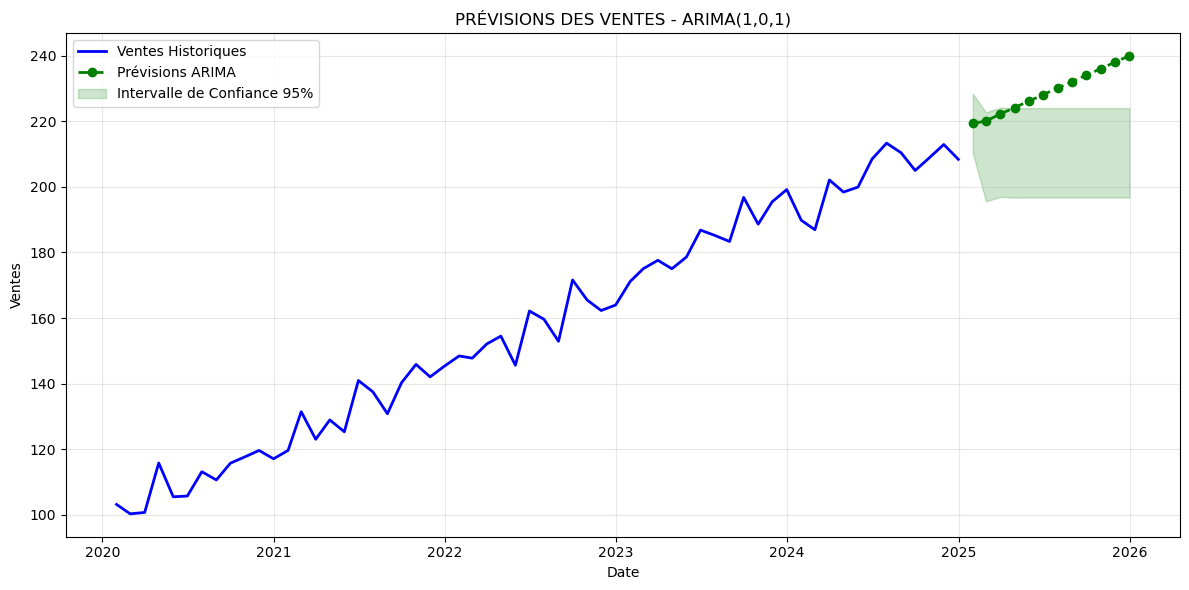


🔍 ANALYSE DES RÉSIDUS :
   • Moyenne des résidus: -0.1506
   • Écart-type des résidus: 4.7786
   • Test Ljung-Box (p-value): 0.7058


In [15]:
## Model ARIMA
# 1. FAIRE LES PRÉVISIONS
forecast_steps = 12  # Prévoir les 12 prochains mois
arima_forecast = model_fit.get_forecast(steps=forecast_steps)
arima_forecast_mean = arima_forecast.predicted_mean
arima_forecast_ci = arima_forecast.conf_int()

# 2. CRÉER LES DATES DE PRÉVISION
last_date = data['Date'].iloc[-1]
forecast_dates = pd.date_range(start=last_date + pd.DateOffset(months=1), periods=forecast_steps, freq='ME')

# 3. CONVERTIR LES PRÉVISIONS EN NIVEAU ORIGINAL
last_sales_value = data['Sales'].iloc[-1]

# Reconstruction de la série originale
arima_forecast_original = []
current_value = last_sales_value

for i in range(len(arima_forecast_mean)):
    diff_value = arima_forecast_mean.iloc[i]
    current_value = current_value + diff_value
    arima_forecast_original.append(current_value)

# Créer la série avec les bonnes dates
arima_forecast_original = pd.Series(arima_forecast_original, 
                                    index=forecast_dates,
                                    name='Sales_forecast')

# 6. MÉTRIQUES DE PRÉCISION
print(f"\n📈 Performance du modèle :")
print(f"   AIC: {model_fit.aic:.2f}")
print(f"   BIC: {model_fit.bic:.2f}")
print(f"   Log-Likelihood: {model_fit.llf:.2f}")

# 7. VISUALISATION DES PRÉVISIONS
plt.figure(figsize=(12, 6))

# Données historiques
plt.plot(data['Date'], data['Sales'], label='Ventes Historiques', color='blue', linewidth=2)

# Prévisions
plt.plot(arima_forecast_original.index, arima_forecast_original, 
         label='Prévisions ARIMA', color='green', linestyle='--', linewidth=2, marker='o')

# Intervalles de confiance
arima_forecast_ci_original_lower = last_sales_value + arima_forecast_ci.iloc[:, 0].values
arima_forecast_ci_original_upper = last_sales_value + arima_forecast_ci.iloc[:, 1].values

plt.fill_between(forecast_dates, 
                 arima_forecast_ci_original_lower,
                 arima_forecast_ci_original_upper,
                 color='green', alpha=0.2, label='Intervalle de Confiance 95%')

plt.title('PRÉVISIONS DES VENTES - ARIMA(1,0,1)')
plt.xlabel('Date')
plt.ylabel('Ventes')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 8. ANALYSE DES RÉSIDUS
print(f"\n🔍 ANALYSE DES RÉSIDUS :")
residuals = model_fit.resid

print(f"   • Moyenne des résidus: {residuals.mean():.4f}")
print(f"   • Écart-type des résidus: {residuals.std():.4f}")

# Test de Ljung-Box
from statsmodels.stats.diagnostic import acorr_ljungbox
try:
    lb_test = acorr_ljungbox(residuals, lags=1, return_df=True)
    lb_pvalue = lb_test['lb_pvalue'].iloc[0]
    print(f"   • Test Ljung-Box (p-value): {lb_pvalue:.4f}")
except:
    print("   • Test Ljung-Box: Non disponible")
